This work is for the NEURL-GA 3042 Computational Neuroscience course taught by Professor Xiao-jing Wang in Fall 2022. 

### Part 1 and Part 2

In [309]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

In [310]:
# set parameters
from math import tau
from symbol import funcdef
from tracemalloc import start


V_th = -50 # mV
V_reset = -60 # mV
tau_ref = 2 # ms
C = 0.5 # nF
GL = 0.025 # mu S
V_L = -70 # mV
V_spike = 20 # mV

def LIF_model(t_start,t_end,sim_start,sim_end,I_mag,dt=0.01):
    # t_start: current injection time (start)
    # t_end: current injection time (end)
    # sim_start: start time of simulation
    # sim_end: ending time of simulation
    # I_mag: magnitude of injected DC current
    # dt: step size of time

    xx = np.zeros(int((sim_end-sim_start)/dt+1)) # voltage record 
    ii = np.zeros(int((sim_end-sim_start)/dt+1)) # current record
    timestampcoll = np.arange(0,sim_end+dt,dt) # timestamp roll
    
    xx[0] = V_L
    ii[0] = 0
    cnt = 1
    spike_count = 0
    rec_cross = []

    for t in timestampcoll[:-1]:
        I = 0
        # if during the current pulse, set the current 
        if t > t_start and t < t_end:
            I = I_mag
        # otherwise 0
        ii[cnt] = I
        # if current is 0, the membrane potential is the resting state 
        if ii[cnt] == 0:
            xx[cnt] = V_L
        else:
            # if recently spike and during the refractory period, set to V_reset
            if len(rec_cross) != 0 and t <= rec_cross[-1]+tau_ref:
                xx[cnt] = V_reset
            else:
                # if out the refractory period, clear the spike time
                if len(rec_cross) != 0 and t > rec_cross[-1]+tau_ref:
                    rec_cross = []
                # forward euler
                dev = (-GL*(xx[cnt-1]-V_L)+I)/C
                xx[cnt] = xx[cnt-1] + dev*dt
                # if across the threshold, trigger action potential
                if xx[cnt] > V_th:
                    xx[cnt] = V_spike
                    rec_cross.append(t)
                    spike_count += 1
        
        cnt += 1
    return [spike_count,xx,ii,timestampcoll]


Text(0.5, 1.0, 'Voltage dynamics of LIF when I=0.55nA')

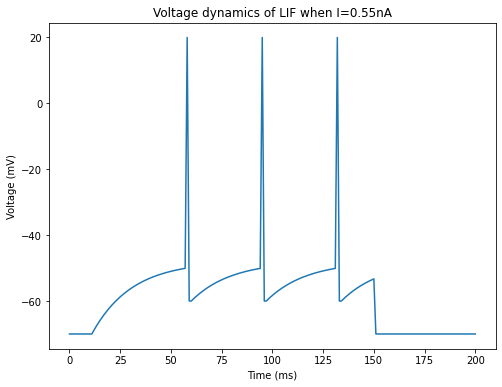

In [311]:
sim_start = 0  # ms
sim_end = 200  # ms
starttime = sim_start + 10 # ms
endtime = sim_end - 50  # ms

I_curr = 0.55
[spiketime,xx1,ii1,timestampcoll] = LIF_model(starttime,endtime,sim_start,sim_end,I_curr,1)

plt.figure(figsize=(8,6))
plt.plot(timestampcoll,xx1)
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.title(f'Voltage dynamics of LIF when I={I_curr}nA')



Text(0, 0.5, 'Frequency f (spike )')

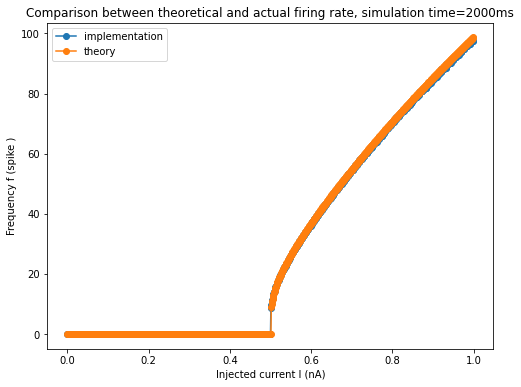

In [315]:
I_lst = np.arange(0.0,1.0,0.001)
SC_lst = []
f_lst = []

sim_start = 0  # ms
sim_end = 2000  # ms
starttime = sim_start + 10 # ms
endtime = sim_end - 50  # ms

for icurr in I_lst:
    [spiketime,xx1,ii1,timestampcoll] = LIF_model(starttime,endtime,sim_start,sim_end,icurr,0.1)
    SC_lst.append(spiketime)
    f = spiketime/(endtime-starttime)
    f_lst.append(f)


res = [idx for idx, val in enumerate(SC_lst) if val != 0]
fc = res[0]
I_c = I_lst[fc]

# Theory (Equation 4 in Chap 2)
tf_lst = []
for icurr in I_lst:
    if icurr <= I_c:
        tf_lst.append(0)
    else:
        val = tau_ref+C/GL*np.log(1+GL*(V_th-V_reset)/(icurr-I_c))
        tf_lst.append(1/val)

# change units
f_lst = [i * 1000 for i in f_lst]
tf_lst = [i * 1000 for i in tf_lst]

plt.figure(figsize=(8,6))
plt.plot(I_lst,f_lst,'-o',label='implementation')
plt.plot(I_lst,tf_lst,'-o',label='theory')
plt.legend()
plt.title(f'Comparison between theoretical and actual firing rate, simulation time={sim_end-sim_start}ms')
plt.xlabel('Injected current I (nA)')
plt.ylabel('Frequency f (spike )')


### Part 3

Text(0.5, 1.0, 'Just Above I_c, simulation time: 200ms')

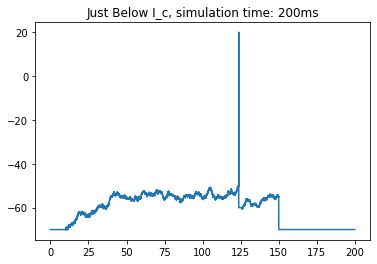

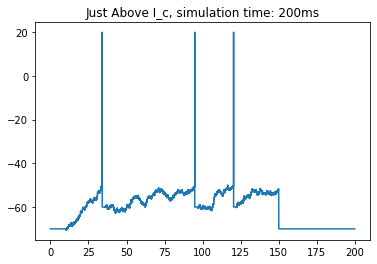

In [333]:
# SDE version of LIF model, where the time derivative is partly decided by the white-noise w(t)
# that is sampled from the Gaussian distribution as the probablity density. 

sim_start = 0  # ms
sim_end = 200  # ms
starttime = sim_start + 10 # ms
endtime = sim_end - 50  # ms

def stochastic_LIF_model(t_start,t_end,sim_start,sim_end,I_mag,dt=0.01):
    # t_start: current injection time (start)
    # t_end: current injection time (end)
    # sim_start: start time of simulation
    # sim_end: ending time of simulation
    # I_mag: magnitude of injected DC current
    # dt: step size of time

    xx = np.zeros(int((sim_end-sim_start)/dt+1)) # voltage record 
    ii = np.zeros(int((sim_end-sim_start)/dt+1)) # current record
    timestampcoll = np.arange(0,sim_end+dt,dt) # timestamp roll
    
    xx[0] = V_L
    ii[0] = 0
    cnt = 1
    spike_count = 0
    rec_cross = []
    spike_record = []

    # define parameter in noise level
    mu = 0
    # To may the smooth effect clearer, purposefully make sigma larger
    sigma = 1.0

    for t in timestampcoll[:-1]:
        I = 0
        # generate white noise
        rr = np.random.normal(mu,sigma)
        # if during the current pulse, set the current 
        if t > t_start and t < t_end:
            I = I_mag
        # otherwise 0
        ii[cnt] = I
        # if current is 0, the membrane potential is the resting state 
        if ii[cnt] == 0:
            xx[cnt] = V_L
        else:
            # if recently spike and during the refractory period, set to V_reset
            if len(rec_cross) != 0 and t <= rec_cross[-1]+tau_ref:
                xx[cnt] = V_reset
            else:
                # if out the refractory period, clear the spike time
                if len(rec_cross) != 0 and t > rec_cross[-1]+tau_ref:
                    rec_cross = []
                # forward euler
                dev = (-GL*(xx[cnt-1]-V_L)+I)/C
                xx[cnt] = xx[cnt-1] + dev*dt + sigma*np.sqrt(dt)*rr
                # if across the threshold, trigger action potential
                if xx[cnt] > V_th:
                    xx[cnt] = V_spike
                    rec_cross.append(t)
                    spike_record.append(t)
                    spike_count += 1
        
        cnt += 1
    return [spike_count,spike_record,xx,ii,timestampcoll]

[spiketime,spike_record,xx1,ii1,timestampcoll1] = stochastic_LIF_model(starttime,endtime,sim_start,sim_end,0.49,0.01)
[spiketime,spike_record,xx2,ii2,timestampcoll2] = stochastic_LIF_model(starttime,endtime,sim_start,sim_end,0.51,0.01)


plt.figure()
plt.plot(timestampcoll1,xx1)
plt.title(f'Just Below I_c, simulation time: {sim_end-sim_start}ms')
plt.figure()
plt.plot(timestampcoll2,xx2)
plt.title(f'Just Above I_c, simulation time: {sim_end-sim_start}ms')

Text(0, 0.5, 'CV - f')

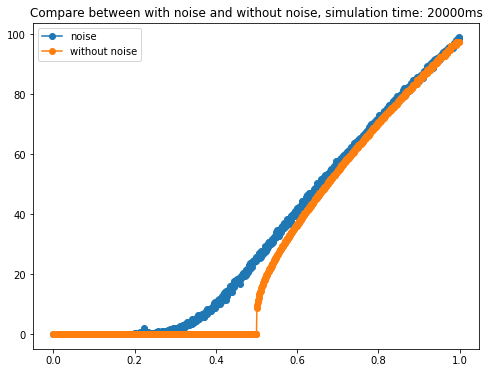

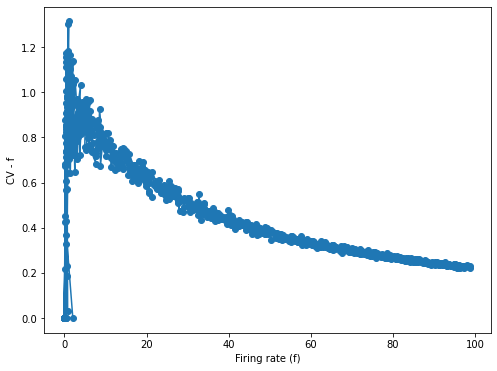

In [334]:
I_lst = np.arange(0.0,1.0,0.001)
f_noise_lst = []
# calculate the coefficient of variation (CV) of the interspike intervals
# CV = std(ISI)/mean(ISI)
CV_lst = [] 

sim_start = 0  # ms
sim_end = 20000  # ms
starttime = sim_start + 10 # ms
endtime = sim_end - 50  # ms

for icurr in I_lst:
    [spiketime,spike_record,xx1,ii1,timestampcoll] = stochastic_LIF_model(starttime,endtime,sim_start,sim_end,icurr,0.1)
    # calculate the firing rate f as the inverse of mean interspike intervals
    if len(spike_record) == 0:
        f_noise_lst.append(0)
        CV_lst.append(0)
    else:
        difflst = [spike_record[i+1]-spike_record[i] for i in range(len(spike_record)-1)]
        if len(difflst) == 0:
            f_noise_lst.append(0)
            CV_lst.append(0)
        else:
            nn = np.mean(difflst)
            stdn = np.std(difflst)
            f_noise_lst.append(1/nn)
            CV_lst.append(stdn/nn)

# change unit
f_noise_lst = [i * 1000 for i in f_noise_lst]

plt.figure(figsize=(8,6))
plt.plot(I_lst,f_noise_lst,'-o',label='noise')
plt.plot(I_lst,f_lst,'-o',label='without noise')
plt.legend()
plt.title(f'Compare between with noise and without noise, simulation time: {sim_end-sim_start}ms')

plt.figure(figsize=(8,6))
plt.plot(f_noise_lst,CV_lst,'-o')
plt.xlabel('Firing rate (f)')
plt.ylabel(f'CV - f')